In [1]:
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from Domain.Nutzenergieanalyse import NEAData

import Bevoelkerung
import Domain.General
import Energiebilanz
import General
import Nutzenergieanalyse
import Processor
import Utils


def create_general_data(g_laender_factory: Domain.General.GLaenderFactory):
    g_sektoren_factory = General.GSektorenDefaultFactory()
    g_bereiche_factory = General.GBereicheSimpleFactory()
    g_energietraeger_klassen_factory = General.GEnergietraegerKlassenSimpleFactory()
    g_energietraeger_factory = General.GEnergietraegerSimpleFactory()
    g_data_factory = General.GDataFactory(g_laender_factory, g_sektoren_factory, g_bereiche_factory,
                                          g_energietraeger_klassen_factory, g_energietraeger_factory)
    g_data = g_data_factory.create()
    return g_data

def create_nea_data(g_data: Domain.General.GData):
    nea_data_pickle_factory = Nutzenergieanalyse.NEADataPickleFactory(pathlib.Path('Data/Serialization'))
    nea_data_factory = Nutzenergieanalyse.NEADataETKlassenFactory(nea_data_pickle_factory)
    nea_data = nea_data_factory.create(g_data).data
    return {land.name: {sektor.name: {bereich.name: nea_data[land][sektor][bereich] for bereich in nea_data[land][sektor].keys()} for sektor in nea_data[land].keys()} for land in nea_data.keys()}

def create_eb_data(g_data: Domain.General.GData):
    eb_data_pickle_factory = Energiebilanz.EBDataPickleFactory(pathlib.Path('Data/Serialization'))
    eb_data_factory = Energiebilanz.EBDataETKlassenFactory(eb_data_pickle_factory)
    eb_data = eb_data_factory.create(g_data).data
    return {land.name: {sektor.name: eb_data[land][sektor] for sektor in eb_data[land].keys()} for land in eb_data.keys()}

def create_b_data(g_data: Domain.General.GData):
    b_data_factory = Bevoelkerung.BDataPickleFactory(pathlib.Path('Data/Serialization'), list(general_data.laender.values()))
    b_data = b_data_factory.create(list(general_data.laender.values())).data
    return {land.name: b_data[land] for land in b_data.keys()}
    
laender_factory = General.GBundeslaenderFactory()
general_data = create_general_data(laender_factory)

nea_data = create_nea_data(general_data)
eb_data = create_eb_data(general_data)
b_data = create_b_data(general_data)


In [2]:
def create_nea_data_sektor(land: str, sektor: str):
    return sum([nea_data[land][sektor][bereich.name] for bereich in general_data.bereiche.values()])

def create_nea_data_land(land: str):
    return sum([create_nea_data_sektor(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_nea_data_bereich_oesterreich(sektor: str, bereich: str):
    return sum([nea_data[land.name][sektor][bereich] for land in general_data.laender.values()])

def create_nea_data_sektor_oesterreich(sektor: str):
    return sum([create_nea_data_sektor(land.name, sektor) for land in general_data.laender.values()])

def create_nea_data_oesterreich():
    return sum([create_nea_data_land(land.name) for land in general_data.laender.values()])

In [3]:
def clean_negative_values(data):
    df = data.copy()
    df[df < 0] = 0
    return df

def calc_relative(df: pd.DataFrame):
    return (df.transpose() / df.sum(axis=1)).transpose()


In [4]:
extrapolation = Utils.DFLinearExtrapolation()
extension = Utils.DFNanExtension()
extrapolation_extension = Utils.DFExtrapolationExtension(extrapolation)


In [5]:
def extend_nea_data(land: str, sektor: str, bereich: str):
    s = create_nea_data_sektor(land, sektor)
    b = nea_data[land][sektor][bereich]
    rel = (b / s).fillna(0)
    eb = eb_data[land][sektor]
    rel_ex = extrapolation_extension.run(rel, pd.PeriodIndex(pd.period_range(start='1988', end='2020', freq='A'), name=rel.index.name))
    return rel_ex * eb

def extend_all_nea_data():
    return {land: {sektor: {bereich: extend_nea_data(land, sektor, bereich) for bereich in nea_data[land][sektor].keys()} for sektor in nea_data[land].keys()} for land in nea_data.keys()}

nea_data_ex = extend_all_nea_data()


In [6]:
def create_data_bereich(land: str, sektor: str, bereich: str):
    nea = nea_data_ex[land][sektor][bereich]
    bevoelkerung = b_data[land]
    bevoelkerung = pd.Series(bevoelkerung, pd.period_range('1988', '2040', freq='A')).interpolate()
    nea_pp = (nea.transpose() / bevoelkerung['1988':'2020']).transpose().rolling(3).mean()['1990':]
    nea_pp_ex = extrapolation_extension.run(nea_pp, pd.PeriodIndex(pd.period_range(start=nea_pp.index[0], end='2040', freq='A'), name=nea_pp.index.name))
    return (clean_negative_values(nea_pp_ex.transpose()) * bevoelkerung['1990':]).transpose()

def create_data_sektor(land: str, sektor: str):
    return sum([create_data_bereich(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_land(land: str):
    return sum([create_data_sektor(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_oesterreich():
    return sum([create_data_land(land.name) for land in general_data.laender.values()])


In [7]:
def create_data_bereich_2(land: str, sektor: str, bereich: str):
    nea = nea_data_ex[land][sektor][bereich]
    bevoelkerung = b_data[land]
    bevoelkerung = pd.Series(bevoelkerung, pd.period_range('1988', '2040', freq='A')).interpolate()
    nea_pp = (nea.transpose() / bevoelkerung['1988':'2015']).transpose().rolling(3).sum()['1990':]
    nea_pp_ex = extrapolation_extension.run(nea_pp, pd.PeriodIndex(pd.period_range(start=nea_pp.index[0], end='2040', freq='A'), name=nea_pp.index.name))
    return (clean_negative_values(nea_pp_ex.transpose()) * bevoelkerung['1990':]).transpose()

def create_data_sektor_2(land: str, sektor: str):
    return sum([create_data_bereich_2(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_land_2(land: str):
    return sum([create_data_sektor_2(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_oesterreich_2():
    return sum([create_data_land_2(land.name) for land in general_data.laender.values()])


In [8]:
heizen_ph_wien = create_data_bereich('tirol', 'Wohngebäude', 'Heizen')['1990':'2020']
heizen_ph_wien


,Fossile fest,Fossile flüssig,Fossile gasförmig,Brennbare Abfälle,Scheitholz,Biogene,Erneuerbare,Fernwärme,Elektrische Energie
1990,1116.557402,6925.412620,278.309843,0.0,3858.836654,66.072763,27.779687,227.130286,904.232674
1991,1065.764571,6874.324832,342.095643,0.0,3968.998873,70.633974,31.487747,249.366419,935.613589
1992,1013.776515,6804.250589,400.342061,0.0,4042.727287,74.273696,35.995068,238.349257,963.250773
1993,959.119347,6848.538037,433.294125,0.0,4149.013677,79.094555,41.272071,261.877809,985.138632
1994,877.720369,6696.533854,411.694400,0.0,4062.336968,80.341483,44.910312,262.313541,977.437542
1995,806.787868,7066.939391,423.418622,0.0,4194.826481,85.143556,46.850214,269.522111,966.459773
1996,707.760493,7415.769030,479.894262,0.0,4263.491852,85.050381,46.824873,278.245628,941.513622
1997,581.223721,7484.951283,545.193477,0.0,4311.387003,106.475084,46.819608,292.714342,902.392194
1998,452.043787,7485.533879,601.234387,0.0,4262.958445,133.137714,46.787729,298.866589,864.761824
1999,354.562826,7431.074785,595.607771,0.0,4193.926005,165.811617,46.778440,322.332343,847.543760


In [9]:
data = nea_data_ex['wien']['Wohngebäude']['Heizen']['Fossile fest']

In [10]:
data

1988    2071.940148
1989    1665.880296
1990    1489.008889
1991    1660.491135
1992    1240.028201
1993     931.050432
1994     805.413024
1995     725.920416
1996     678.693132
1997     499.988081
1998     434.212272
1999     389.482008
2000     380.530959
2001     393.572834
2002     404.550498
2003     409.247238
2004     381.418424
2005     181.195145
2006     166.435841
2007      37.262199
2008      37.963667
2009      27.195096
2010      31.076815
2011     116.743915
2012     124.638636
2013      48.756073
2014      39.113066
2015       7.467088
2016       7.664656
2017       9.964228
2018       8.896231
2019       7.939638
2020       7.860208
Freq: A-DEC, Name: Fossile fest, dtype: float64

In [11]:
adfuller(data)

(-1.9173368793910768,
 0.32394976097350153,
 5,
 27,
 {'1%': -3.6996079738860943,
  '5%': -2.9764303469999494,
  '10%': -2.627601001371742},
 239.89113808430375)

This results in an ADF statistic of -1.91 and a p-value of 0.32. Here, the ADF statistic is not a large negative number and the p-value is greater than 0.05. Therefore, our time series is not stationary and we must apply transformations to make it stationary.

In [12]:
adfuller(data.diff()[1:])

(-5.285341957619576,
 5.871743261264857e-06,
 0,
 31,
 {'1%': -3.661428725118324,
  '5%': -2.960525341210433,
  '10%': -2.6193188033298647},
 232.4927072924417)

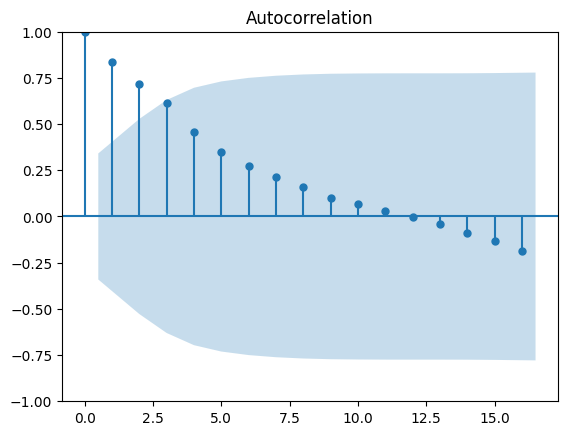

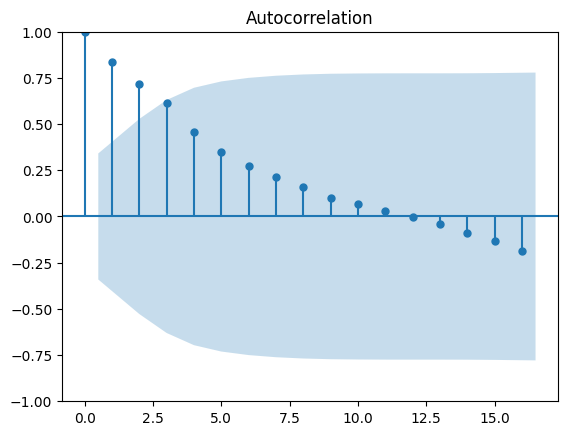

In [13]:
plot_acf(data)

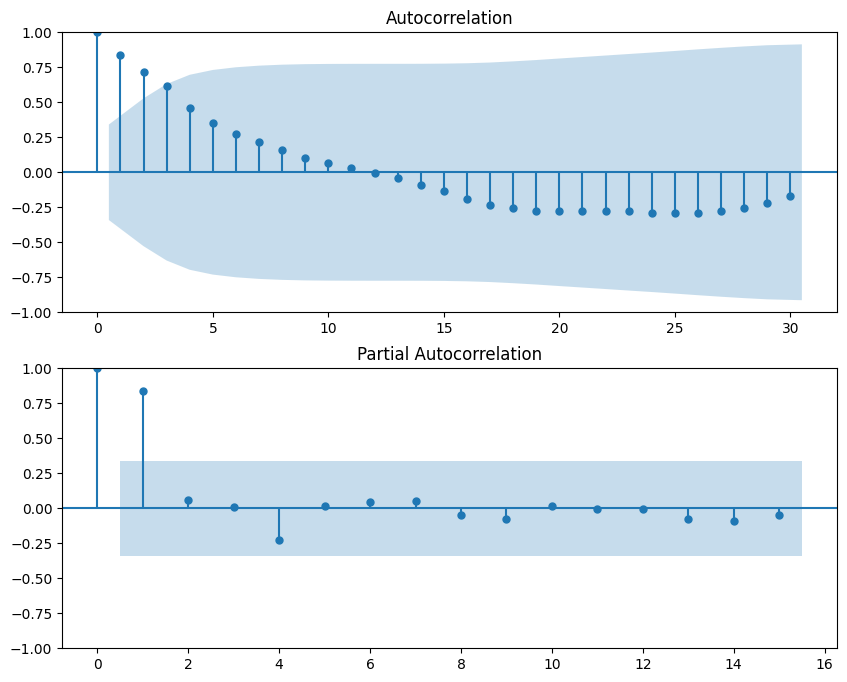

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data, ax=ax1, lags=30)
plot_pacf(data, ax=ax2, lags=15)
plt.show()


<Axes: >

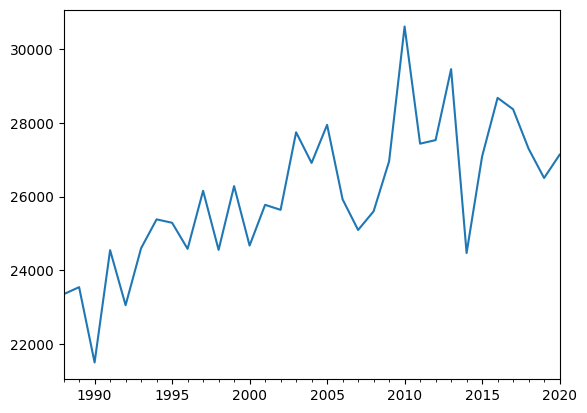

In [15]:
nea_data_ex['wien']['Wohngebäude']['Heizen'].sum(axis=1).plot()

In [16]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# #############################################################################
# Load the data and split it into separate pieces
data = create_data_bereich('wien', 'Wohngebäude', 'Heizen').sum(axis=1)
train, test = model_selection.train_test_split(data['2005':'2020'], train_size=10)

# Fit a simple auto_arima model
arima = pm.auto_arima(train, seasonal=True)

# #############################################################################
# Plot actual test vs. forecasts:


In [17]:
predict = arima.predict(n_periods=26)
pd.concat([data[:'2020'], predict['2021':]])

1990    22910.521580
1991    23392.154070
1992    23283.127795
1993    24302.758563
1994    24440.870300
1995    25048.729566
1996    25054.222919
1997    25352.949011
1998    25104.027684
1999    25708.642433
2000    25285.764145
2001    25721.289992
2002    25628.311552
2003    26696.602584
2004    27081.038618
2005    27889.905007
2006    27215.790402
2007    26504.278424
2008    25684.007621
2009    26027.099802
2010    27899.568442
2011    28539.951330
2012    28814.579863
2013    28523.146644
2014    27593.183667
2015    27497.476241
2016    27270.388536
2017    28489.210245
2018    28390.518270
2019    27573.533585
2020    27131.068195
2021    27684.754671
2022    27340.457059
2023    27109.382344
2024    27097.839681
2025    27260.502657
2026    27462.421354
2027    27577.982137
2028    27561.059624
2029    27452.768774
2030    27337.124951
2031    27282.488107
2032    27305.889112
2033    27375.371291
2034    27439.997904
2035    27463.689008
2036    27442.488618
2037    27399

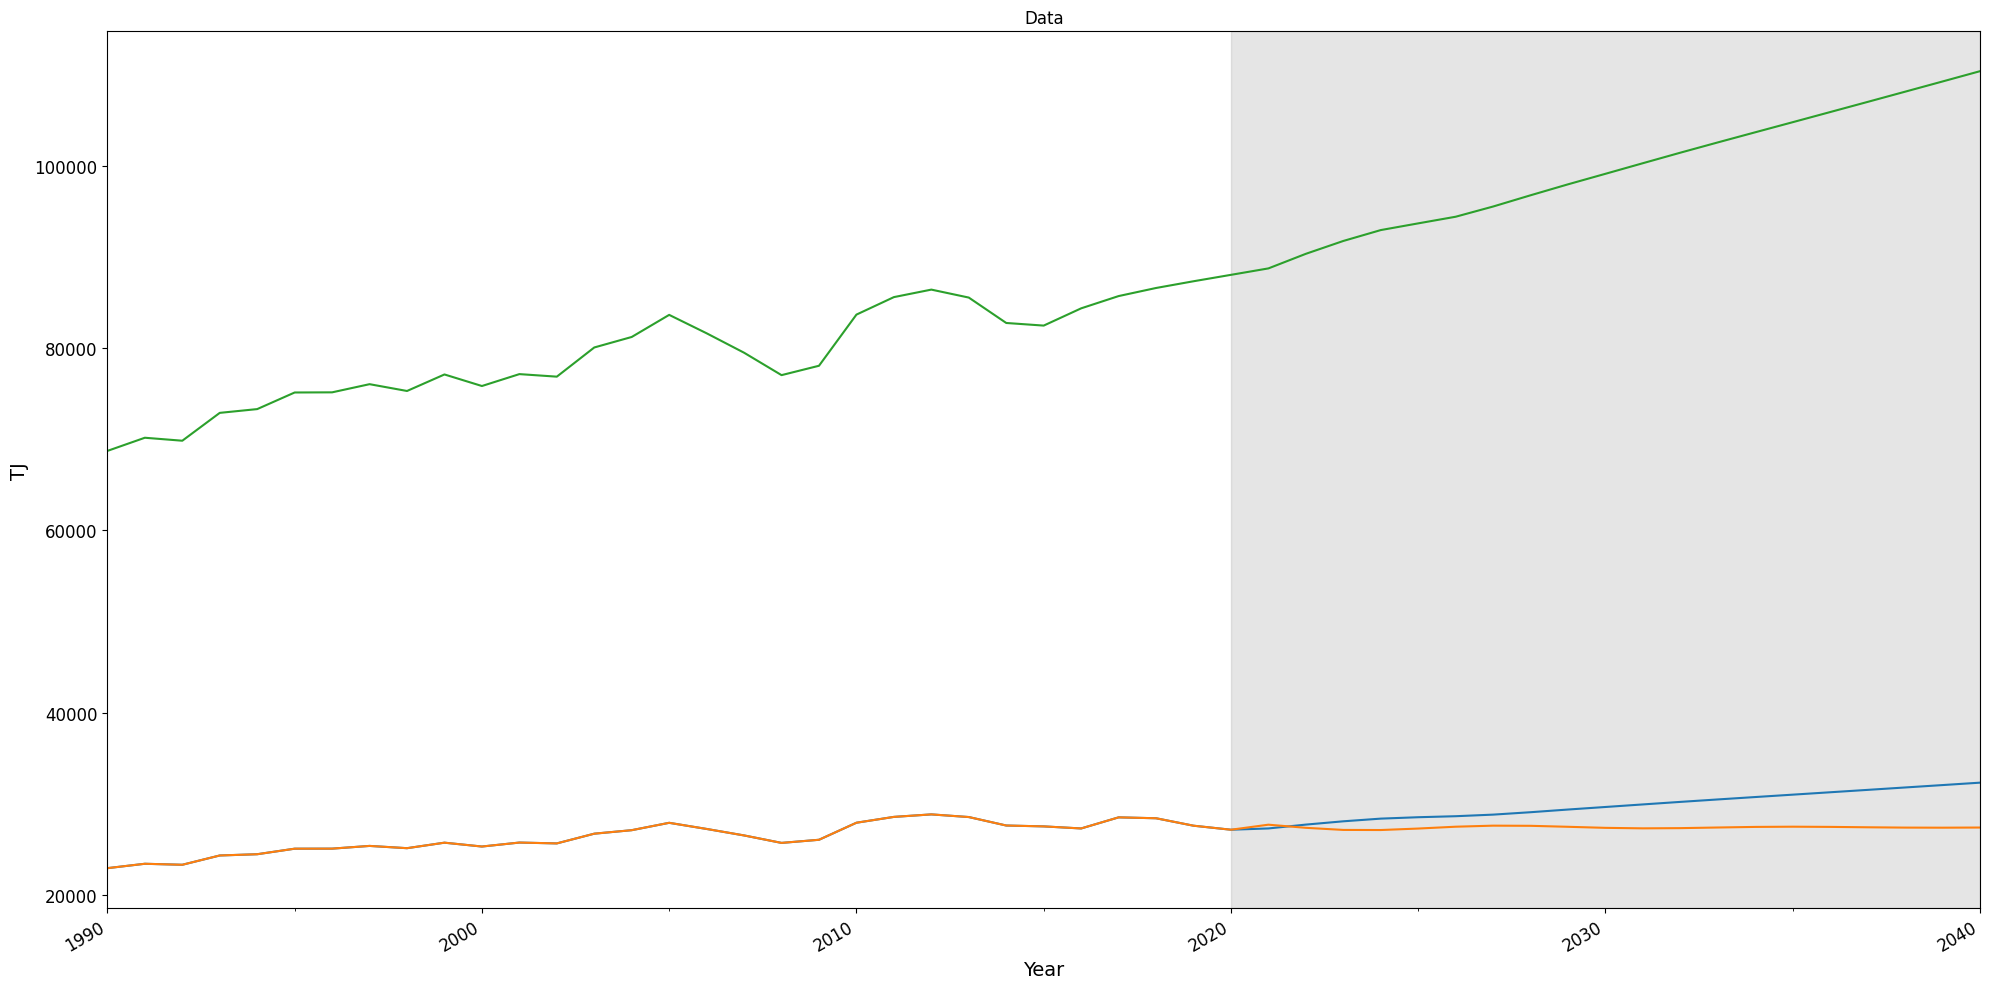

In [18]:
def since_epoch(period):
    return (period - pd.Period('1970-01-01', freq=period.freq)).n

matplotlib.rcParams["figure.figsize"] = (20,10)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=False)

data.plot(ax=ax1)
ax1.set_title('Data')
ax1.set_xlabel('Year')
ax1.set_ylabel('TJ')


predict = arima.predict(n_periods=26)
predict2 = pd.concat([data[:'2020'], predict['2021':]])
predict2.plot(ax=ax1)

data2 = create_data_bereich_2('wien', 'Wohngebäude', 'Heizen').sum(axis=1)
data2.plot(ax=ax1)
ax1.axvspan(since_epoch(data['2020':].index[0]), since_epoch(data.index[-1:][0]), color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [19]:
predict.name = "asd"
predict

2015    26769.515588
2016    26501.467822
2017    26811.907831
2018    27385.038859
2019    27828.502583
2020    27917.531976
2021    27684.754671
2022    27340.457059
2023    27109.382344
2024    27097.839681
2025    27260.502657
2026    27462.421354
2027    27577.982137
2028    27561.059624
2029    27452.768774
2030    27337.124951
2031    27282.488107
2032    27305.889112
2033    27375.371291
2034    27439.997904
2035    27463.689008
2036    27442.488618
2037    27399.238057
2038    27364.073269
2039    27355.337312
2040    27371.805501
Freq: A-DEC, Name: asd, dtype: float64

In [20]:
def extend_arima_series(series):
    train, test = model_selection.train_test_split(series['1990':'2020'], train_size=25)
    arima = pm.auto_arima(train, seasonal=True)
    predict = arima.predict(n_periods=26)
    return pd.concat([train, predict])

def extend_arima(df):
    return pd.DataFrame([extend_arima_series(df[col]) for col in df.columns]).transpose()
        

In [21]:
asd = extend_arima(create_data_bereich('wien', 'Wohngebäude', 'Heizen')['1990':'2020'])

C:\dev\MasterProject\venv\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


In [22]:
asd

,0,1,2,3,4,5,6,7,8
1990,1751.357835,2709.259367,13721.224700,0.0,500.894298,33.735207,13.623819,3304.781908,875.644445
1991,1618.783405,2797.221592,13820.970671,0.0,523.461057,34.321486,15.033881,3668.261475,914.100503
1992,1480.229009,2846.473198,13523.428829,0.0,530.723519,34.779962,16.729878,3908.052974,942.710426
1993,1292.131775,2893.962778,14320.561309,0.0,569.916170,35.244944,18.669594,4201.848065,970.423928
1994,997.028473,2694.305895,14899.820635,0.0,588.542351,34.838743,21.269143,4241.513402,963.551658
1995,819.355582,2672.568493,15324.036531,0.0,673.454365,34.877610,24.159028,4541.776393,958.501565
1996,735.688481,2795.324079,14710.715251,0.0,797.110957,34.860367,27.387639,5018.415053,934.721092
1997,635.118978,2823.597339,14472.379551,0.0,923.119152,35.821559,30.230405,5535.398597,897.283430
1998,537.773255,2769.159703,14108.355214,0.0,977.002440,36.372010,33.112309,5781.867231,860.385521
1999,442.002914,2584.371734,15099.479698,0.0,956.503204,34.512552,35.648772,5711.310791,844.812770


<Axes: >

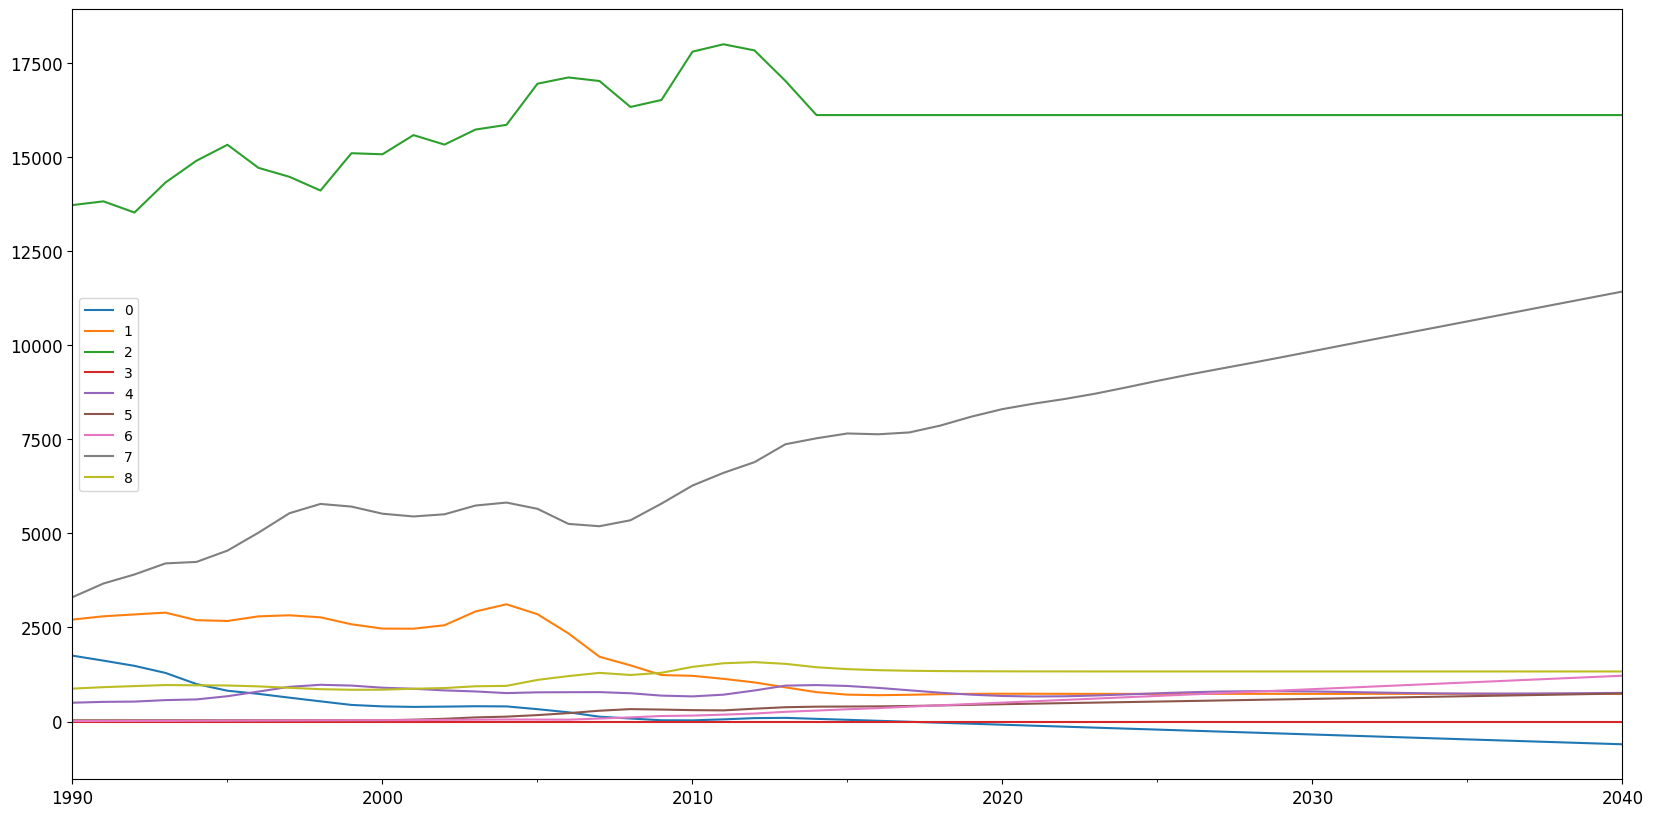

In [23]:
asd.plot()

<Axes: >

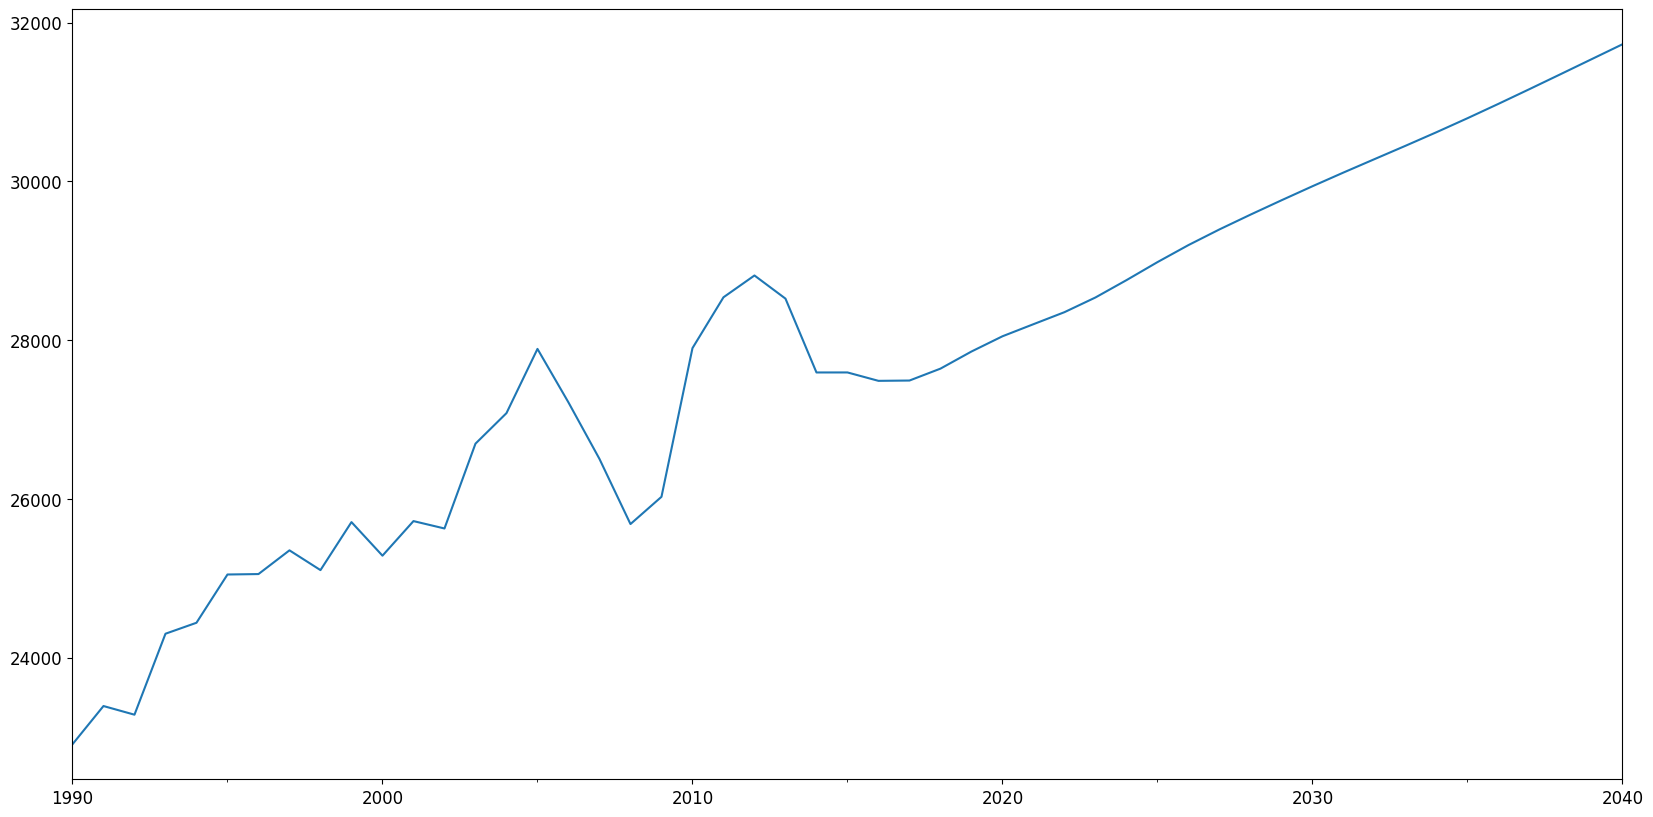

In [24]:
asd.sum(axis=1).plot()


<Axes: >

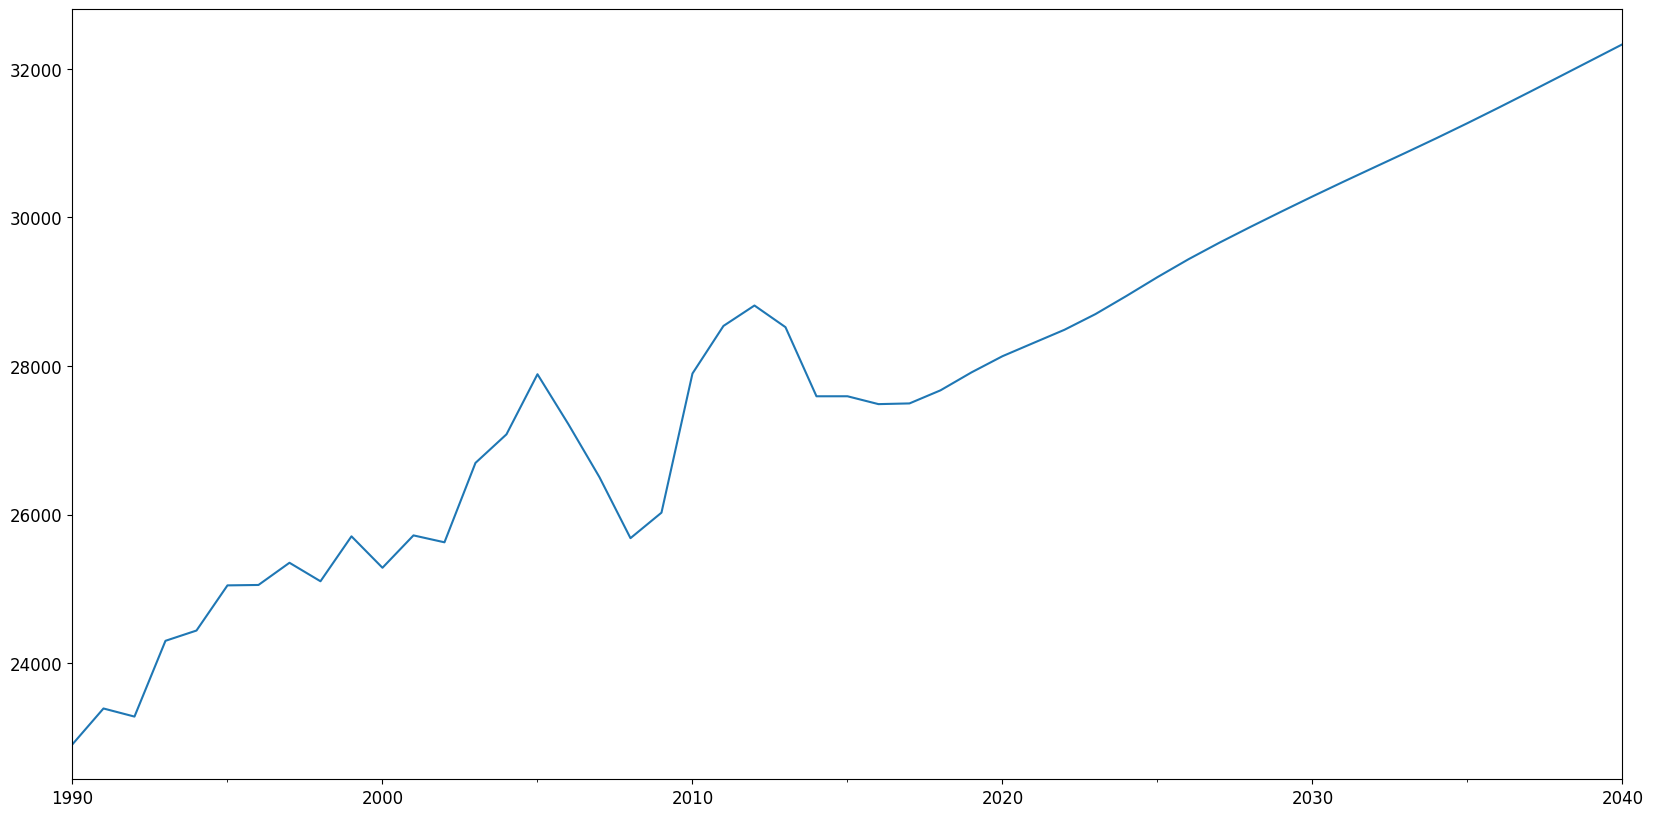

In [25]:
def clean_negative_values(data):
    df = data.copy()
    df[df < 0] = 0
    return df

clean_asd = clean_negative_values(asd)
clean_asd.sum(axis=1).plot()


In [26]:
p_data = create_data_bereich('wien', 'Wohngebäude', 'Heizen')['1990':'2020']


In [27]:

p_ds = p_data.index.to_timestamp()
p_y = p_data['Fossile fest']
p_df = pd.DataFrame([p_ds, p_y]).transpose()
p_df.columns = ['ds', 'y']
p_df['cap'] = 10000

In [28]:
from prophet import Prophet

m = Prophet(growth='logistic')
m.fit(p_df)
future = m.make_future_dataframe(periods=20, freq='AS')
future['cap'] = 10000
future

ModuleNotFoundError: No module named 'prophet'

In [ ]:
forecast = m.predict(future)
forecast

In [ ]:
m.plot(forecast)